# Downstream CIFAR10 Classification

In [33]:
from baseline import BaselineModel
from torchsummary import summary
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
random_model = BaselineModel().to(device)
pretext_model_state_dict = torch.load('baseline.pth', map_location=device)
pretext_model = BaselineModel().to(device)
pretext_model.load_state_dict(pretext_model_state_dict)

<All keys matched successfully>

In [35]:
def change_head_to_CIFAR10_classifier(model, freeze_encoder=True):
    classifier_head = [
        #torch.nn.Conv2d(128,16,kernel_size=1,stride=1,padding=0,bias=True),
        torch.nn.Flatten(),
        torch.nn.Linear(512, 128),
        torch.nn.ReLU(True),
        torch.nn.BatchNorm1d(128),
        torch.nn.Linear(128,10),
        torch.nn.Softmax(dim=1)
    ]

    model.decoder = torch.nn.Sequential(*classifier_head)
    if freeze_encoder:
        model.encoder.requires_grad_(False)
    return model

random_model = change_head_to_CIFAR10_classifier(random_model, freeze_encoder=False)
pretext_model = change_head_to_CIFAR10_classifier(pretext_model, freeze_encoder=False)
summary(random_model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             544
              ReLU-2           [-1, 32, 16, 16]               0
       BatchNorm2d-3           [-1, 32, 16, 16]              64
            Conv2d-4             [-1, 64, 8, 8]          32,832
              ReLU-5             [-1, 64, 8, 8]               0
       BatchNorm2d-6             [-1, 64, 8, 8]             128
            Conv2d-7            [-1, 128, 4, 4]         131,200
              ReLU-8            [-1, 128, 4, 4]               0
       BatchNorm2d-9            [-1, 128, 4, 4]             256
           Conv2d-10            [-1, 128, 2, 2]         262,272
             ReLU-11            [-1, 128, 2, 2]               0
      BatchNorm2d-12            [-1, 128, 2, 2]             256
          Flatten-13                  [-1, 512]               0
           Linear-14                  [

### Hyperparameters

In [19]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch import cuda

learning_rate = 1e-3
batch_size = 512
random_model_optimizer = Adam(random_model.parameters(), lr=learning_rate)
pretext_model_optimizer = Adam(pretext_model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()
epochs = 10
device = 'cuda' if cuda.is_available() else 'cpu'

## Load CIFAR10

In [20]:
import numpy as np
from skimage import color

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2,0,1)))

img_transform = transforms.Compose([
    transforms.Lambda(import_image),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=img_transform, target_transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=img_transform, target_transform=None)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Training

In [21]:
random_model.train()

print('Training random model...')

random_train_loss_avg = []

for epoch in range(epochs):
    random_train_loss_avg.append(0)
    num_batches = 0

    for batch, labels in train_loader:
        batch = batch.to(device)

        batch_input = batch[:,0:1,:,:]
        random_prediction = random_model(batch_input)
    
        labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)

        loss = criterion(random_prediction, labels)
        random_model_optimizer.zero_grad()
        loss.backward()
        random_model_optimizer.step()
        random_train_loss_avg[-1] += loss.item()

        num_batches += 1

    random_train_loss_avg[-1] /= num_batches
    print(f"Epoch {epoch+1}/{epochs} average random error: {random_train_loss_avg[-1]}")


Training random model...
Epoch1/10 average random error: 2.1612143297584687
Epoch2/10 average random error: 2.091313464300973
Epoch3/10 average random error: 2.0604371489310753
Epoch4/10 average random error: 2.0357798605549093
Epoch5/10 average random error: 2.012807166089817
Epoch6/10 average random error: 1.9921687342682664
Epoch7/10 average random error: 1.971690519731872
Epoch8/10 average random error: 1.9551134644722452
Epoch9/10 average random error: 1.9361970886892201
Epoch10/10 average random error: 1.9197371821014249


In [26]:
pretext_model.train()

print('Training pretext model...')

pretext_train_loss_avg = []

for epoch in range(epochs):
    pretext_train_loss_avg.append(0)
    num_batches = 0

    for batch, labels in train_loader:
        batch = batch.to(device)

        batch_input = batch[:,0:1,:,:]
        pretext_prediction = pretext_model(batch_input)

        labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)

        loss = criterion(pretext_prediction, labels)
        pretext_model_optimizer.zero_grad()
        loss.backward()
        pretext_model_optimizer.step()
        pretext_train_loss_avg[-1] += loss.item()

        num_batches += 1

    pretext_train_loss_avg[-1] /= num_batches
    print(f"Epoch {epoch+1}/{epochs} average pretext error: {pretext_train_loss_avg[-1]}")


Training pretext model...
Epoch1/10 average pretext error: 1.9554011663612054
Epoch2/10 average pretext error: 1.9352370305937163
Epoch3/10 average pretext error: 1.918421352396206
Epoch4/10 average pretext error: 1.9029030690387803
Epoch5/10 average pretext error: 1.887261696007787
Epoch6/10 average pretext error: 1.8736209893713192
Epoch7/10 average pretext error: 1.859249777939855
Epoch8/10 average pretext error: 1.845372993118909
Epoch9/10 average pretext error: 1.8336306117018875
Epoch10/10 average pretext error: 1.8211000500893106


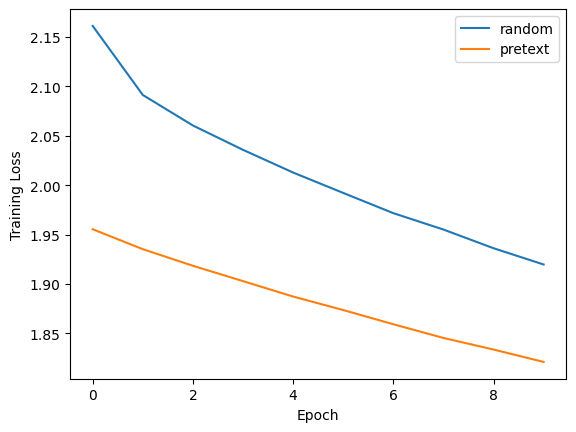

In [27]:
# plot the training loss
import matplotlib.pyplot as plt

plt.plot(random_train_loss_avg, label='random')
plt.plot(pretext_train_loss_avg, label='pretext')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

In [36]:
# set to evaluation mode
random_model.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, labels in test_loader:

    with torch.no_grad():

        lab_batch = lab_batch.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
        prediction = random_model(lab_batch[:, 0:1, :, :])

        # loss is the L2 error to the actual color (ab) components
        loss = criterion(prediction, labels)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 2.301620


In [37]:
# set to evaluation mode
pretext_model.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, labels in test_loader:

    with torch.no_grad():

        lab_batch = lab_batch.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
        prediction = pretext_model(lab_batch[:, 0:1, :, :])

        # loss is the L2 error to the actual color (ab) components
        loss = criterion(prediction, labels)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 2.303379
